In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())

test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())

100.1%

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


28.4%

0.5%

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [4]:
train_dict={}
for (data, target) in train_data:
    if  target not in train_dict:
        train_dict[ target]=[]
        train_dict[ target].append(data)
    else:
        train_dict[ target].append(data)

In [5]:
initial_train_data=[]
initial_train_label=[]
for i in range(10):
    initial_train_data.append(train_dict[i][0])
    initial_train_label.append(i)
    
print(initial_train_label)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
initial_train_data_tensor=torch.stack(initial_train_data)
initial_train_label_tensor=torch.tensor(initial_train_label)
print(initial_train_data_tensor.size())
print(initial_train_label_tensor.size())

torch.Size([10, 1, 28, 28])
torch.Size([10])


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.final_weight=nn.init.xavier_uniform_(torch.empty(10, 10,requires_grad = True),0.1)

    def forward(self, x):
        x=x.view(1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x= torch.matmul(x,self.final_weight)
        return F.log_softmax(x,dim=-1)
    
    def prediction(x):
        output = torch.exp(self.forward(x))
        pred = output.data.max(x, keepdim=True)[1]
        return pred.item()
    
    def uncertainty(x,label):
        output = torch.exp(self.forward(i))
        loss = F.nll_loss(output,torch.tensor([label]))+torch.norm(network.final_weight,2)
        jacobian_w=jacobian(output,self.final_weight)
        hessian_w=hessian(loss,self.final_weight)
        hessian_inverse=torch.inverse(hessian_w)
        left=torch.matmul(jacobian_w,hessian_inverse)
        (sign, logdet) = np.linalg.slogdet(pos_cov.detach().numpy()) 
        entropy=5+5*np.log(2*np.pi)+0.5*logdet
        return entropy
#         print('entropy',entropy)

    
    
network = Net()
#optimizer = optim.SGD(network.parameters(), lr=0.5,
#                       momentum=0.1)
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [21]:
import matplotlib.pyplot as plt
def train():
    network.train()
    train_losses = []
    for it in range(0,2000):
        optimizer.zero_grad()
        output = network(initial_train_data_tensor)
        loss = F.nll_loss(output,initial_train_label_tensor)+torch.norm(network.final_weight,2)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    plt.plot(train_losses)
    plt.show()

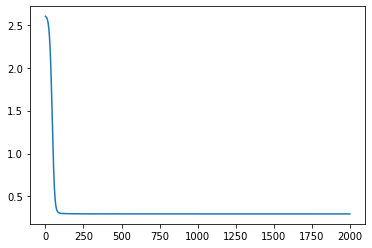

In [22]:
train()

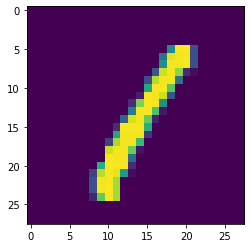

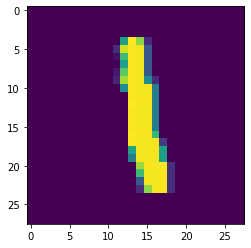

In [23]:
old_data=train_dict[1][0]
new_data=train_dict[1][1]
plt.imshow(old_data[0])
plt.show()
plt.imshow(new_data[0])
plt.show()

In [80]:
from hessian import *
import numpy as np

for i in train_dict[1][0:10]:
    output = torch.exp(network(i.view(1,1,28,28)))
    pred = output.data.max(1, keepdim=True)[1]
    print('prediction',pred.item())
    loss = F.nll_loss(output,torch.tensor([1]))+torch.norm(network.final_weight,2)
    jacobian_w=jacobian(output,network.final_weight)
    hessian_w=hessian(loss,network.final_weight)
    hessian_inverse=torch.inverse(hessian_w)
    left=torch.matmul(jacobian_w,hessian_inverse)
    pos_cov=torch.matmul(left,jacobian_w.t())
    #pos_gaussian=multivariate_normal(cov=pos_cov)
    (sign, logdet) = np.linalg.slogdet(pos_cov.detach().numpy()) 
    entropy=5+5*np.log(2*np.pi)+0.5*logdet
    print('entropy',entropy)

prediction 1
entropy -207.68089970213296
prediction 3
entropy -19.82964237791421
prediction 8
entropy -2.240569196761868
prediction 8
entropy -15.674824796737454
prediction 1
entropy -200.15576847654702
prediction 2
entropy -4.891255460799954
prediction 8
entropy -43.33288487058999
prediction 1
entropy -189.52880009275796
prediction 1
entropy -129.00411137205484
prediction 5
entropy -100.39156254392984
